In [5]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)



<module 'stats' from 'C:\\Users\\dell\\stats.py'>

- number of cores, set this number according to your computer

In [6]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [7]:
product_list = ["IF", "IH", "IC", "T", "TF"]

- sample period

In [8]:
period = 4096

- get all of the days

In [9]:
import dask
from dask import compute, delayed

In [10]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1092

In [11]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

- let's begin with week 6

- this week we focus on portfolio optimization which gives weights to each strategy


- we have got several signals and each signals have several strategies right now
- let's put them together now


- we can write a function to generage signal backtesting result

- first we create a directory to save the signal backtesting result

- then we can write a function to perform the job

In [12]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [13]:
import random
## choosen good strategy from training samples and apply them on test samples
def get_chosen_strategy(product_list, result_dire, save_name, min_pnl_dict,min_num=20):
    random.seed(100) ## set some random numbers, so that we can select different portfolio for each time， 
    ## because if we choose all of them then the total number would be too large
    os.makedirs(HEAD_PATH+"/"+save_name, exist_ok=True)
    for dire in ["trend", "reverse"]: ## including trend and reversal stratgies
        for product in product_list: ## iterator all products
            chosen_strategy = dict() ## final chosen set
            pnl_mat = None ## chosen pnl of all strategies
            spread = product_info[product]["spread"]  ## bid-ask spread of the product
            min_pnl = min_pnl_dict[product]*spread ## minimum required pnl to avoid spllipage effect
            train_stat = None ## train result
            test_stat = None ## test result
            for y in signal_list: ## iterate over the signal list
                result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+y+".pkl")[dire+".signal.stat"]
                if "train.stat" in result.keys():
                    train_stat = result["train.stat"]
                    test_stat = result["test.stat"]
                    avg_pnl = train_stat["final.result"]["avg.pnl"].rolling(3, center=True).mean() ## use rolling mean of 3 results to avoid outlier
                    avg_pnl.fillna(0, inplace=True)
                    good_strat = (avg_pnl>=min_pnl) & (train_stat["final.result"]["avg.pnl"]>=min_pnl)  & (train_stat["final.result"]["num"]>=min_num)
                    if sum(good_strat)==0: ## no good strategies 
                        continue;
                    elif sum(good_strat)<=5: ## too few good strategies
                        chosen_strategy[y] = good_strat
                    elif sum(good_strat)>5: ## too many good strategies
                        chosen =np.random.choice(sum(good_strat), 5, replace=False) 
                        ## just select 5 of them randomly, because for mean-variance we could not handle too many columns
                        good_strat = np.array(np.where(good_strat))[0,chosen]
                        chosen_strategy[y] = good_strat
                    if pnl_mat is None:
                        pnl_mat = train_stat["daily.ret"].loc[:, good_strat].values
                    else:
                        pnl_mat = np.hstack((pnl_mat, train_stat["daily.ret"].loc[:, good_strat].values))
            save((chosen_strategy, pnl_mat), HEAD_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl")

- now we check how it performs in the test samples

In [14]:
## get the pnl for test samples
def get_test_mat(pnl_mat, signal_name):
    for dire in ["trend","reverse"]: ## iterate for trend and reverse
        chosen_strategy, train_pnl_mat = load(HEAD_PATH+"/"+save_name+"/"+dire+"/"+product+".pkl") ## get training result
        for signal_name in chosen_strategy: ## iterate for all chosen strategies
            result = load(HEAD_PATH+"/"+result_dire+"/"+product+"."+signal_name+".pkl")[dire+".signal.stat"]
            test_stat = result["test.stat"]
            good_strat = chosen_strategy[signal_name]
            if sum(good_strat)>0:
                if pnl_mat is None:
                    pnl_mat =  test_stat["daily.ret"].loc[:, good_strat].values
                else:
                    pnl_mat = np.hstack((pnl_mat, test_stat["daily.ret"].loc[:, good_strat].values))
    return pnl_mat

- at first we generate result without atr

In [15]:
os.makedirs(HEAD_PATH+"/chosen_strategy_atr", exist_ok=True)
os.makedirs(HEAD_PATH+"/chosen_strategy_atr/trend", exist_ok=True)
os.makedirs(HEAD_PATH+"/chosen_strategy_atr/reverse", exist_ok=True)

In [16]:
min_pnl = dict([])
for product in ["IF","IH","IC"]:
    min_pnl[product] = 10
for product in ["T","TF"]:
    min_pnl[product] = 2
get_chosen_strategy(product_list, "signal result atr", "chosen_strategy_atr", min_pnl_dict=min_pnl, min_num=20)

In [17]:
%%time
all_test_mat=dict([])
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
for product in product_list:
    print(product)
    test_mat = functools.reduce(get_test_mat, signal_list, None)
    all_test_mat[product] = test_mat
    
# IF
# IH
# IC
# T
# TF
# Wall time: 3min 12s




IF
IH
IC
T
TF
Wall time: 3min 12s


- we can draw the plot

IF train sharpe:  1.1445898350568942 test sharpe:  0.3197671479228211
IH train sharpe:  0.5838179800485216 test sharpe:  0.24729015036709848
IC train sharpe:  0.9713473069267163 test sharpe:  0.49050037243766975
T train sharpe:  1.0789820100872678 test sharpe:  0.4669728641976241
TF train sharpe:  1.593354603051057 test sharpe:  -0.22193411588409376
portfolio train sharpe:  1.1519080340247219 test sharpe:  0.40236567127449263


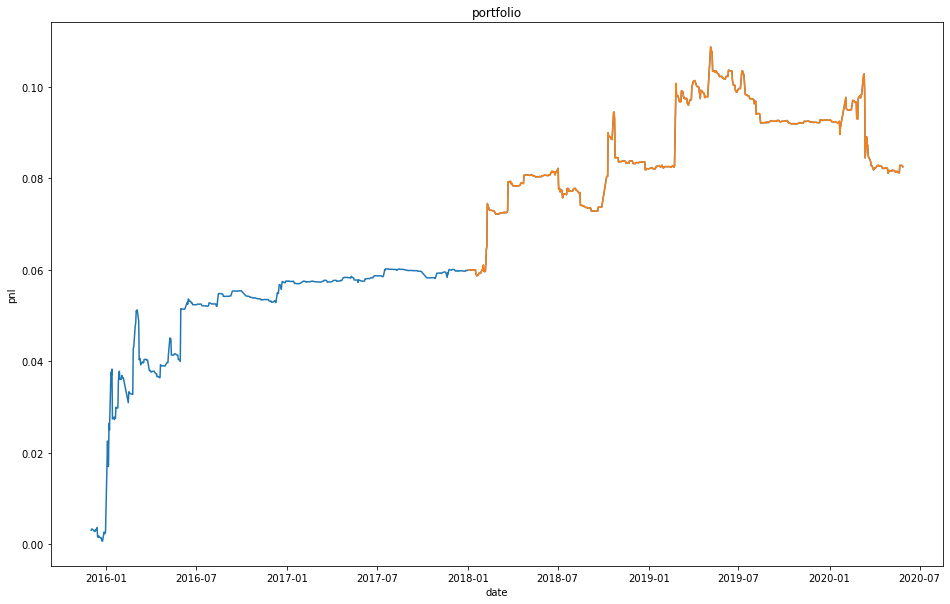

In [74]:
i = 0
result_dire = "signal result atr"
save_name = "chosen_strategy_atr"
n_product = len(product_list)
portfolio = np.zeros((n_days, n_product))
for product in product_list:
    trend_chosen_strategy, trend_pnl_mat = load(HEAD_PATH+"/"+save_name+"/trend/"+product+".pkl")
    reverse_chosen_strategy, reverse_pnl_mat = load(HEAD_PATH+"/"+save_name+"/reverse/"+product+".pkl")
    if len(trend_chosen_strategy)>0 and len(reverse_chosen_strategy)>0:
        pnl_mat =  np.hstack((trend_pnl_mat, reverse_pnl_mat))
    elif len(trend_chosen_strategy)==0:
        pnl_mat = reverse_pnl_mat
    elif len(reverse_chosen_strategy)==0:
        pnl_mat = trend_pnl_mat
    avg_train_pnl = pnl_mat.mean(axis=1)
    avg_test_pnl = all_test_mat[product].mean(axis=1)
    all_pnl = np.append(avg_train_pnl, avg_test_pnl)
    #all_pnl = all_pnl/np.std(avg_train_pnl)
    i = i+1
    portfolio[:,i-1] = all_pnl
    print(product, "train sharpe: ", sharpe(avg_train_pnl),"test sharpe: ", sharpe(avg_test_pnl))

i = i+1
plt.figure(i, figsize=(16, 10))
plt.title("portfolio")
plt.xlabel("date")
plt.ylabel("pnl")
avg_portfolio = portfolio.mean(axis=1)
plt.plot(format_dates, avg_portfolio.cumsum())
plt.plot(format_dates[test_sample], avg_portfolio.cumsum()[test_sample])
print("portfolio", "train sharpe: ", sharpe(avg_portfolio[train_sample]),"test sharpe: ", sharpe(avg_portfolio[test_sample]))

# IF train sharpe:  1.1445898350568942 test sharpe:  0.3197671479228211
# IH train sharpe:  0.5838179800485216 test sharpe:  0.24729015036709848
# IC train sharpe:  0.9713473069267163 test sharpe:  0.49050037243766975
# T train sharpe:  1.0789820100872678 test sharpe:  0.4669728641976241
# TF train sharpe:  1.593354603051057 test sharpe:  -0.22193411588409376
# portfolio train sharpe:  1.1519080340247219 test sharpe:  0.40236567127449263




- at first we try using the mean-variance optimization model


- we need a function to calculate weight of each strategy for a target mean


- here the meaning of each argument is
- m: vector of average daily pnl
- s: covariance matix of daily pnl
- m.star: target daily pnl, which should be within the range of lowest and highest daily pnl

In [19]:
## calculate the weight of mean-variance
def get_weight(m, s, m_star):
    s_inv = np.linalg.inv(s)
    ones = np.repeat(1, len(m))
    s_inv_ones = np.dot(s_inv , ones)
    s_inv_m = np.dot(s_inv , m)
    A = np.dot(m, s_inv_ones)
    B = np.dot(m, s_inv_m)
    C = np.dot(ones, s_inv_ones)
    D = B * C - A**2
    return ((B - m_star * A) * s_inv_ones + (m_star * C - A) * s_inv_m) / D

## page 86 of 《statistical models and methods for financial markets》

- get daily average pnl of each strategy

In [20]:
pnl_mat = portfolio[train_sample,:]
mean_return = pnl_mat.mean(axis=0)
np.shape(pnl_mat)

## (510, 5)

(510, 5)

- get covariance matrix of each strategy

In [21]:
cov_return = np.cov(pnl_mat, rowvar=False)
n_point = 30
n_strat = pnl_mat.shape[1]
m_grid = np.linspace(min(mean_return), max(mean_return), n_point)
m_grid

# array([1.60934935e-05, 2.40181837e-05, 3.19428739e-05, 3.98675641e-05,
#        4.77922543e-05, 5.57169445e-05, 6.36416347e-05, 7.15663249e-05,
#        7.94910151e-05, 8.74157053e-05, 9.53403955e-05, 1.03265086e-04,
#        1.11189776e-04, 1.19114466e-04, 1.27039156e-04, 1.34963846e-04,
#        1.42888537e-04, 1.50813227e-04, 1.58737917e-04, 1.66662607e-04,
#        1.74587297e-04, 1.82511988e-04, 1.90436678e-04, 1.98361368e-04,
#        2.06286058e-04, 2.14210748e-04, 2.22135439e-04, 2.30060129e-04,
#        2.37984819e-04, 2.45909509e-04])

array([1.49079612e-05, 2.28446832e-05, 3.07814051e-05, 3.87181270e-05,
       4.66548490e-05, 5.45915709e-05, 6.25282928e-05, 7.04650148e-05,
       7.84017367e-05, 8.63384586e-05, 9.42751806e-05, 1.02211902e-04,
       1.10148624e-04, 1.18085346e-04, 1.26022068e-04, 1.33958790e-04,
       1.41895512e-04, 1.49832234e-04, 1.57768956e-04, 1.65705678e-04,
       1.73642400e-04, 1.81579122e-04, 1.89515844e-04, 1.97452566e-04,
       2.05389288e-04, 2.13326010e-04, 2.21262731e-04, 2.29199453e-04,
       2.37136175e-04, 2.45072897e-04])

In [22]:
import scipy

In [23]:
E,V = scipy.linalg.eigh(cov_return)
np.all(E > 0)
## True
## it's positive defintie

True

In [24]:
cov_grid = np.repeat(np.nan, n_point)
weight_grid = np.zeros((n_strat, n_point))


In [25]:
s_inv = np.linalg.inv(cov_return)
s_inv

# array([[ 2.54168204e+05, -1.45687587e+05, -5.91977809e+04,
#          1.92342093e+04,  1.84752691e+04],
#        [-1.45687587e+05,  3.16418437e+05, -4.96444396e+04,
#          3.14218494e+04, -1.87398162e+04],
#        [-5.91977809e+04, -4.96444396e+04,  1.08150556e+05,
#         -1.36610562e+04,  9.60278590e+04],
#        [ 1.92342093e+04,  3.14218494e+04, -1.36610562e+04,
#          5.23298209e+06, -6.64607292e+06],
#        [ 1.84752691e+04, -1.87398162e+04,  9.60278590e+04,
#         -6.64607292e+06,  5.32142984e+07]])

array([[ 3.23965153e+05, -1.90267594e+05, -7.51773846e+04,
         2.30622022e+04, -1.61709122e+04],
       [-1.90267594e+05,  3.34989852e+05, -3.30087897e+04,
         4.05484442e+04, -3.90773137e+03],
       [-7.51773846e+04, -3.30087897e+04,  1.07190807e+05,
        -2.09194586e+04,  1.08285135e+05],
       [ 2.30622022e+04,  4.05484442e+04, -2.09194586e+04,
         5.50853663e+06, -7.55339647e+06],
       [-1.61709122e+04, -3.90773137e+03,  1.08285135e+05,
        -7.55339647e+06,  5.62396641e+07]])

In [26]:
for i in range(1, n_point-1):
    w = get_weight(mean_return, cov_return, m_grid[i])
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w
## here we don't use the first value and last value to avoid scientific computing error

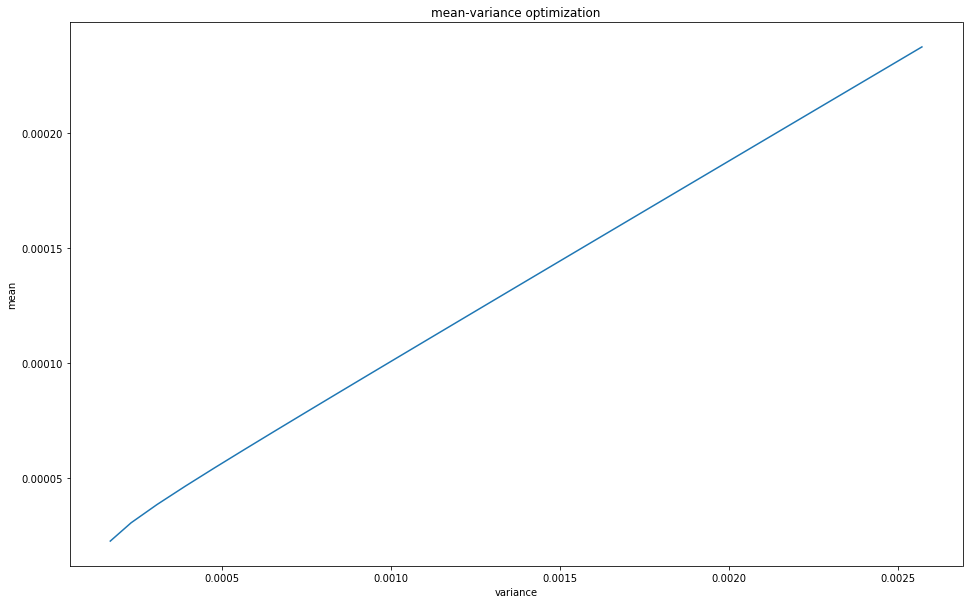

In [27]:
plt.figure(1, figsize=(16, 10))
plt.title("mean-variance optimization")
plt.xlabel("variance")
plt.ylabel("mean")
plt.plot(cov_grid, m_grid);

- to avoid using the mean return we can use risk parity model

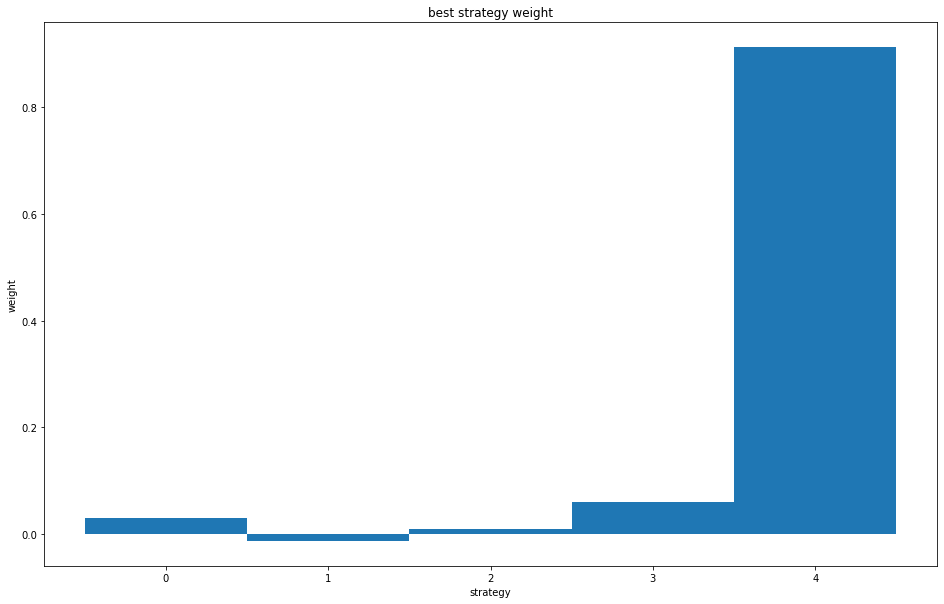

In [28]:
best_index = np.nanargmin(cov_grid)
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(best_weight.index.values, best_weight.values, width=1);

- we can see that there are some negative weights
- although we can do long and short for trading commodities
- here we optimize on the strategies, which we think are good in the training set
- so it does not make sense to short a good strategy
- we also find that there are some large positive and negative weight in magnitude
- it may lead to overfitting to the training data as well
- let's see how to avoid these

- at first  we try to use this without nonnegative constraint


- we construct the matrix to be used in quadratic programming

In [29]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return)).T
n_strat

5

In [30]:
# https://pypi.org/project/quadprog/
# pip install quadprog
# need to download visual studio before running
import quadprog as qp

In [31]:
m_grid[best_index]
# 2.401818368861457e-05

2.2844683152275672e-05

In [32]:
sol = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.array([1, m_grid[best_index]]), meq=2)
sol[0]

## 2.401818368861457e-05

array([ 0.03061848, -0.0133206 ,  0.00986772,  0.05953757,  0.91329683])

In [33]:
sum(abs(sol[0] - best_weight) > 0.00001)

0

In [34]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)))).T
A_mat.shape

(5, 7)

In [35]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.zeros(n_strat))), meq=2)
sol_nneg[0]

# array([0.02183496, 0.        , 0.010281  , 0.07904472, 0.88883931])

array([0.02483959, 0.        , 0.00912415, 0.07089881, 0.89513745])

- we can see that there are many tiny positive values due to rounding error
- so we can use a small positive number to avoid it

In [36]:
sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, b=np.hstack((1, m_grid[best_index], np.repeat(1e-5, n_strat))), meq=2)
sol_nneg[0]

# array([2.18316327e-02, 1.00000000e-05, 1.02799768e-02, 7.90534307e-02,
#        8.88824960e-01])

array([2.48352562e-02, 1.00000000e-05, 9.12359386e-03, 7.09073350e-02,
       8.95123815e-01])

- however, now the problem is that there are too many 1e-5s, and the tenth strategy has portion of 0.59
- that may be overfitting to that strategy
- if it performs worse inthe testing samples our overall result would be very bad
- let's set a limit for the maximum portion of each strategy
- average strategy is 

In [37]:
1/n_strat

0.2

- we can set maximum to be 7%
- but then we may not get the optimal mean values
- so we need to restart the whole optimization scheme again

In [38]:
A_mat = np.vstack((np.repeat(1, n_strat), mean_return, np.diag(np.repeat(1, n_strat)), -np.diag(np.repeat(1, n_strat)))).T
cov_grid = np.repeat(np.nan, n_point)
for i in range(1, n_point-1):
    try:
        sol_nneg = qp.solve_qp(G=cov_return, a=np.zeros(n_strat), C=A_mat, 
                               b=np.hstack((1, m_grid[i], np.repeat(1e-5, n_strat), np.repeat(-0.3, n_strat))), meq=2)
    except ValueError:
        continue
    w = sol_nneg[0]
    cov_grid[i] = np.sqrt(np.dot(np.dot(w, cov_return), w))
    weight_grid[:,i] = w

In [39]:
best_index = np.nanargmin(cov_grid)
weight_grid[:, best_index]

## array([0.3       , 0.09687523, 0.3       , 0.3       , 0.00312477])

array([1.02945746e-01, 2.97044254e-01, 1.00000000e-05, 3.00000000e-01,
       3.00000000e-01])

In [40]:
weight_grid[:, best_index]

array([1.02945746e-01, 2.97044254e-01, 1.00000000e-05, 3.00000000e-01,
       3.00000000e-01])

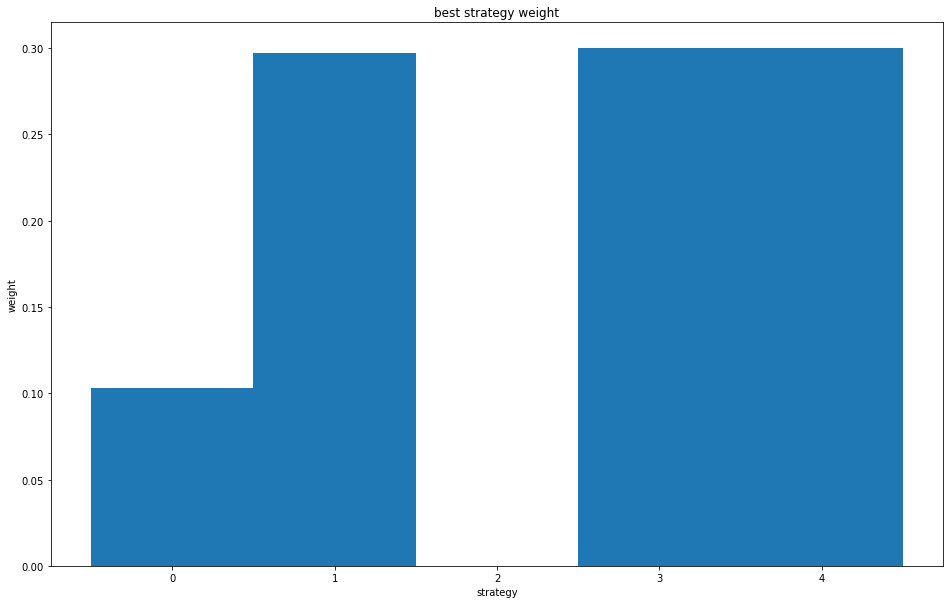

In [41]:
plt.figure(1, figsize=(16, 10))
plt.title("best strategy weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(np.linspace(0, len(weight_grid)-1, len(weight_grid)), weight_grid[:, best_index], width=1);

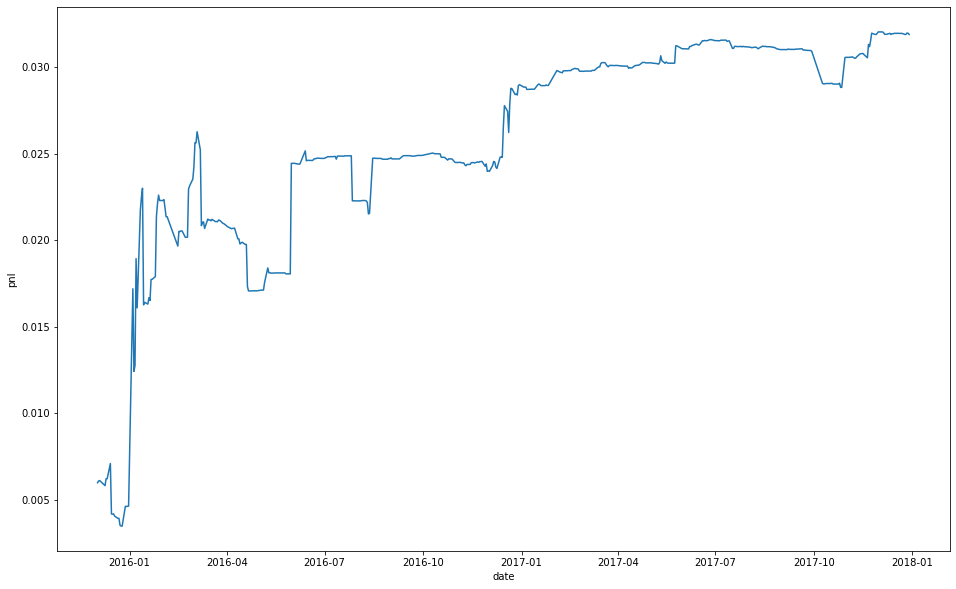

In [42]:
best_weight = weight_grid[:, best_index]
best_weight = pd.Series(best_weight)
best_weight[best_weight<1.1e-5] = 0
train_pnl = np.dot(pnl_mat, best_weight)
train_pnl = pd.Series(train_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pnl.cumsum());

In [43]:
sharpe(train_pnl)
## 2.194066874916852

1.0089722284116542

In [44]:
test_mat = portfolio[test_sample,:]
test_pnl = np.dot(test_mat, best_weight)

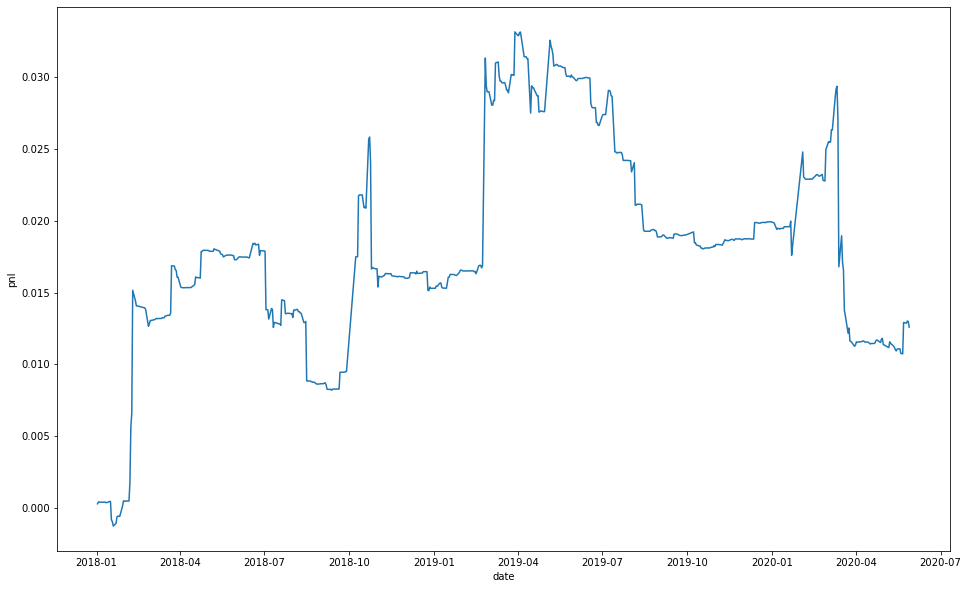

In [45]:
test_pnl = np.dot(test_mat, best_weight)
test_pnl = pd.Series(test_pnl)
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pnl.cumsum());

In [46]:
sharpe(test_pnl)

## 0.2458205760279825

0.2836865646617134

In [47]:
import copy

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''


def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print ('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

In [48]:
from scipy.optimize import minimize
## to calculate total risk
def TotalTRC(x, Cov):
    x = np.append(x, 1-np.sum(x))
    TRC = np.prod((np.dot(Cov, x), x), axis=0)
    if np.sum(x<0)>0: 
        return 10**12
    else:
        return np.sum((TRC[:, None] - TRC) ** 2)

## calculate risk parity, to minimize total risk
def risk_parity(Sub, only_diag=False, maxiter=9999):
    m = Sub.shape[1]
    Cov = np.cov(Sub, rowvar=False)
    if only_diag:
        Cov = np.diag(np.diag(Cov))
    res = minimize(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), method="Nelder-Mead", options={'xtol': 1e-6, "maxiter": maxiter, "disp":True})
    w = np.append(res["x"], 1-np.sum(res["x"]))
    #res = nelder_mead(functools.partial(TotalTRC, Cov=Cov), np.repeat(1/m, m-1), step=1e-3, no_improve_thr=1e-05)
    #w = np.append(res[0], 1-np.sum(res[0]))
    return w

- get weight of risk parity

In [49]:
parity_weight = risk_parity(pnl_mat)
parity_weight = pd.Series(parity_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 243
         Function evaluations: 410


- plot the weight

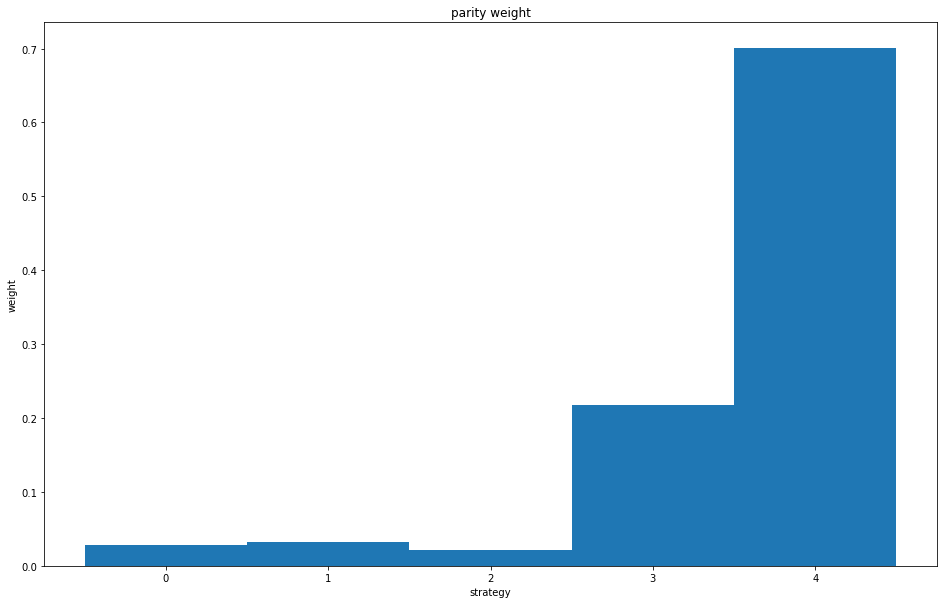

In [50]:
plt.figure(1, figsize=(16, 10))
plt.title("parity weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(parity_weight.index, parity_weight.values, width=1);

- check negative weight

In [51]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [52]:
train_parity = np.dot(pnl_mat, parity_weight)
train_parity = pd.Series(train_parity)

- and plot the final pnl

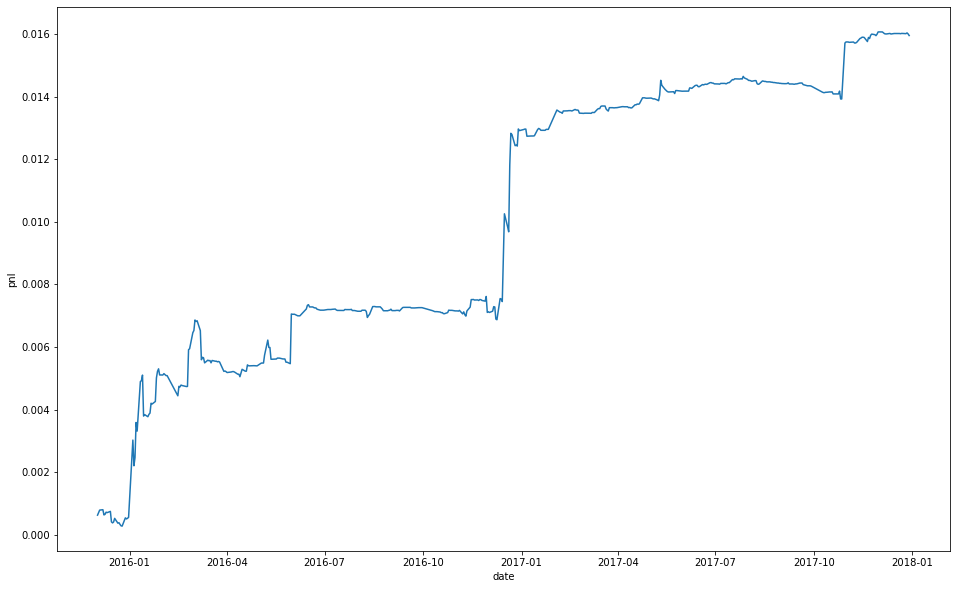

In [53]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_parity.cumsum());

- calculate the sharp ratio

In [54]:
sharpe(train_parity)
## 1.9382219024767517

1.8698198454685677

- now we check the performance on out-of-sample data

In [55]:
test_parity = np.dot(test_mat, parity_weight)
test_parity = pd.Series(test_parity)

- and plot the final pnl

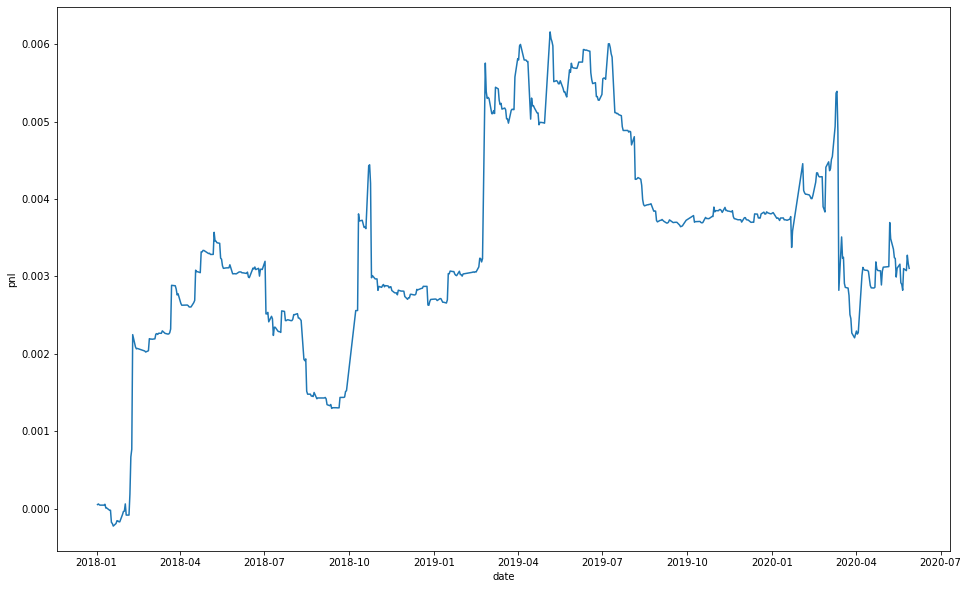

In [56]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_parity.cumsum());

- calculate the sharp ratio

In [57]:
sharpe(test_parity)

## 0.27564913685011116

0.3755791549152322

- now we get back to the estimation of covariance matrix
- somebody claims that we can simply use diagonal values and set other zero
- let's try it

- get weight of risk parity

In [58]:
diagonal_weight = risk_parity(pnl_mat, only_diag=True)
diagonal_weight = pd.Series(diagonal_weight)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 188
         Function evaluations: 321


- plot the weight

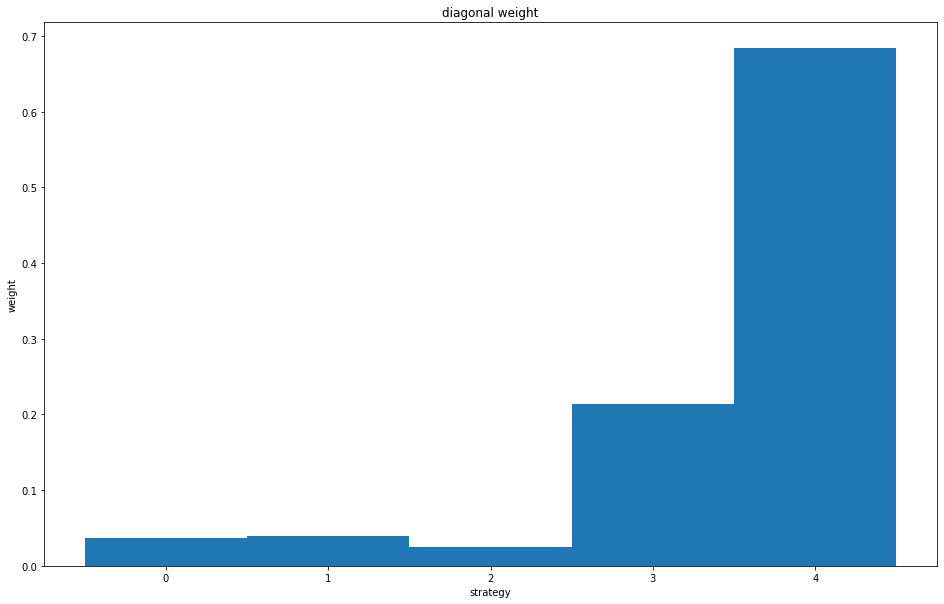

In [59]:
plt.figure(1, figsize=(16, 10))
plt.title("diagonal weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(diagonal_weight.index, diagonal_weight.values, width=1);

- check negative weight

In [60]:
sum(parity_weight<0)
## [1] 0

0

- check the result on training samples

In [61]:
train_diagonal = np.dot(pnl_mat, diagonal_weight)
train_diagonal = pd.Series(train_diagonal)

- and plot the final pnl

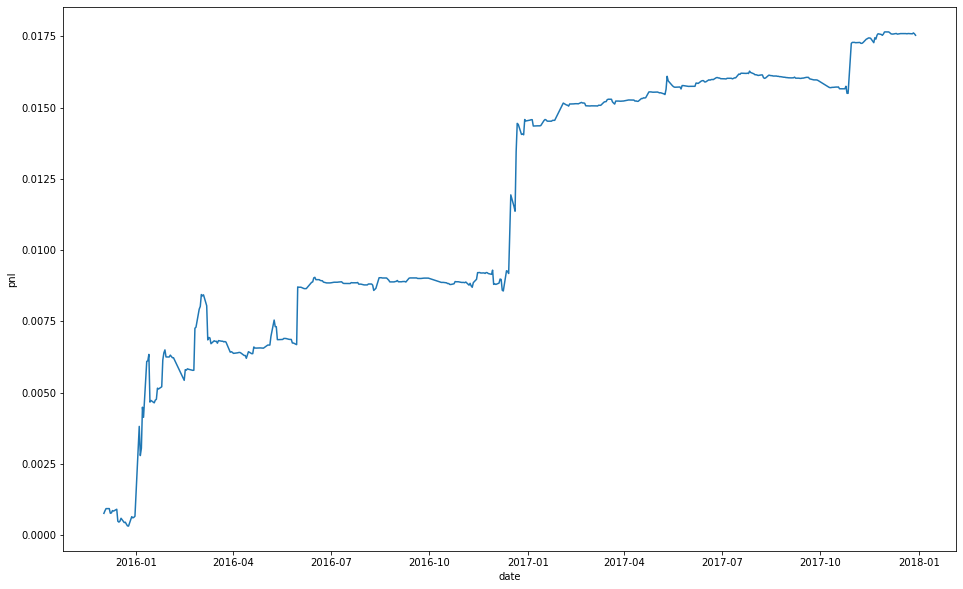

In [62]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_diagonal.cumsum());

- calculate the sharp ratio

In [63]:
sharpe(train_diagonal)
## 1.8398443281196148

1.7870397771832753

- now we check the performance on out-of-sample data

In [64]:
test_diagonal = np.dot(test_mat, diagonal_weight)
test_diagonal = pd.Series(test_diagonal)

- and plot the final pnl

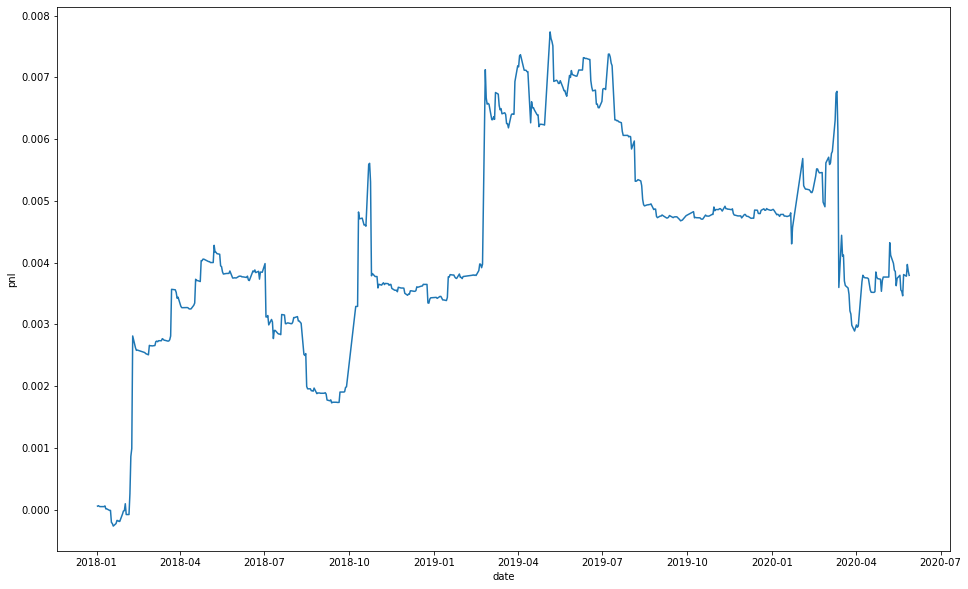

In [65]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_diagonal.cumsum());

- calculate the sharp ratio

In [66]:
sharpe(test_diagonal)
## 0.2897053841116483

0.3764432807397386

- now let's get the next weight: weight based on sharpe ratio

In [67]:
sharpe_mat = np.apply_along_axis(sharpe, 0, pnl_mat)
sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
sharpe_weight = pd.Series(sharpe_weight)
sharpe_weight

# 0    0.204273
# 1    0.099432
# 2    0.179492
# 3    0.207044
# 4    0.309759
# dtype: float64

0    0.213062
1    0.108676
2    0.180814
3    0.200850
4    0.296599
dtype: float64

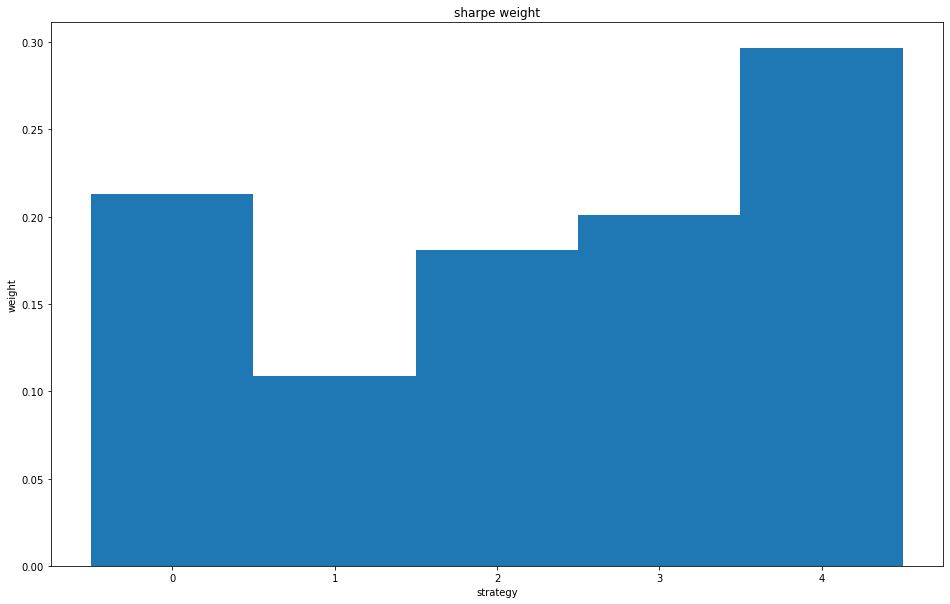

In [68]:
plt.figure(1, figsize=(16, 10))
plt.title("sharpe weight")
plt.xlabel("strategy")
plt.ylabel("weight")
plt.bar(sharpe_weight.index, sharpe_weight.values, width=1);

In [69]:
train_sharpe = np.dot(pnl_mat, sharpe_weight)
train_sharpe = pd.Series(train_sharpe)

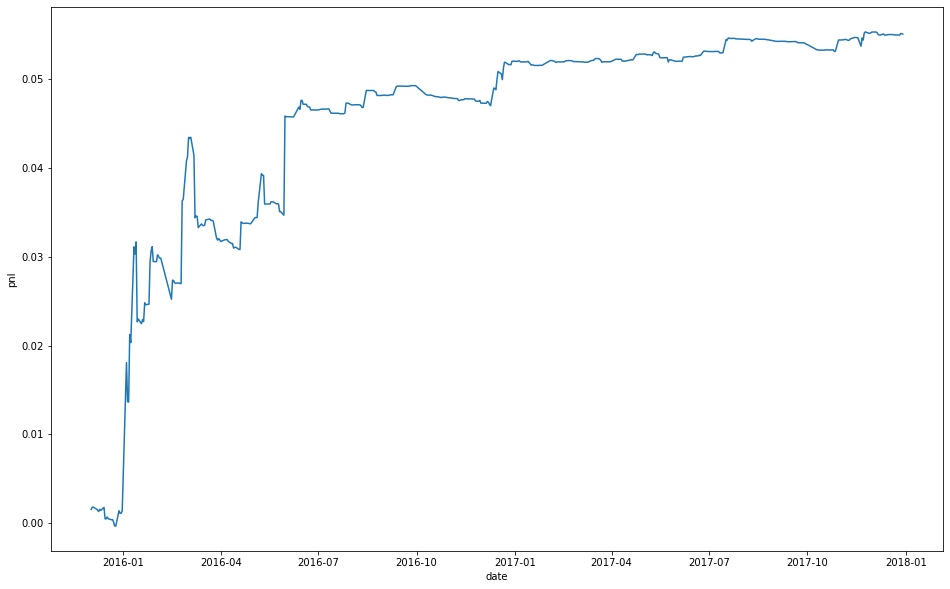

In [70]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_sharpe.cumsum());

In [71]:
sharpe(train_sharpe)
## 1.2536921586781884

1.2325576372046156

In [72]:
test_sharpe = np.dot(test_mat, sharpe_weight)
test_sharpe = pd.Series(test_sharpe)

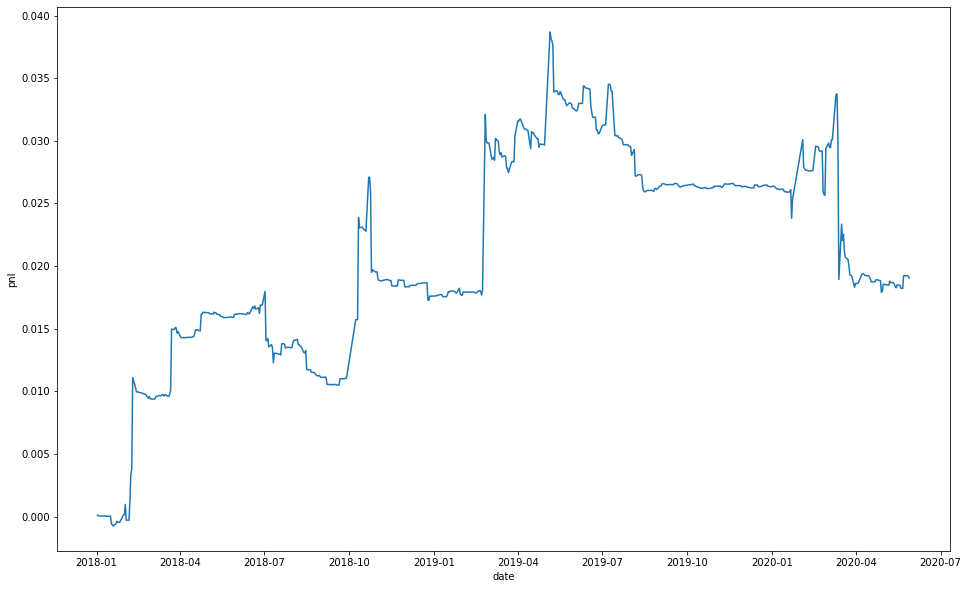

In [73]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_sharpe.cumsum());

In [119]:
sharpe(test_sharpe)
## 0.3829999389300264

0.3829999389300264

- we can see that mean-variance performs the worst while sharpe portfolio performs the best in pnl
- The last part we go to PCA

In [120]:
 from sklearn.decomposition import PCA

In [121]:
pca = PCA(n_components=0.95)
pca.fit(pnl_mat)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [122]:
rotation = pca.components_.transpose()
rotation

# array([[ 4.96497267e-01,  5.98958397e-01,  6.28262516e-01],
#        [ 4.05105180e-01,  4.80185671e-01, -7.77986529e-01],
#        [ 7.67692969e-01, -6.40801303e-01,  4.22884193e-03],
#        [-4.86461078e-03, -6.64580097e-03,  2.28953990e-03],
#        [-2.02426520e-03,  2.88584733e-04, -2.15541277e-04]])

array([[ 4.96497267e-01,  5.98958397e-01,  6.28262516e-01],
       [ 4.05105180e-01,  4.80185671e-01, -7.77986529e-01],
       [ 7.67692969e-01, -6.40801303e-01,  4.22884193e-03],
       [-4.86461078e-03, -6.64580097e-03,  2.28953990e-03],
       [-2.02426520e-03,  2.88584733e-04, -2.15541277e-04]])

In [123]:
train_pca = np.mean(np.matmul(pnl_mat,rotation), axis=1)

In [124]:
sharpe(train_pca)
## 1.1335547104614483

1.1335547104614483

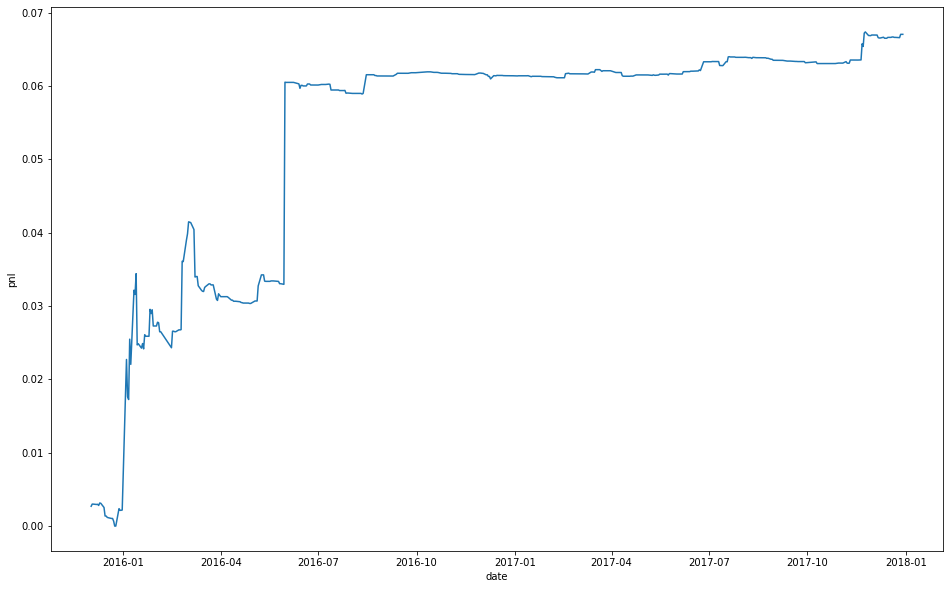

In [125]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[train_sample], train_pca.cumsum())

In [126]:
test_pca = np.mean(np.matmul(test_mat,rotation), axis=1)

In [127]:
sharpe(test_pca)
## 0.2943584826452817

0.2943584826452817

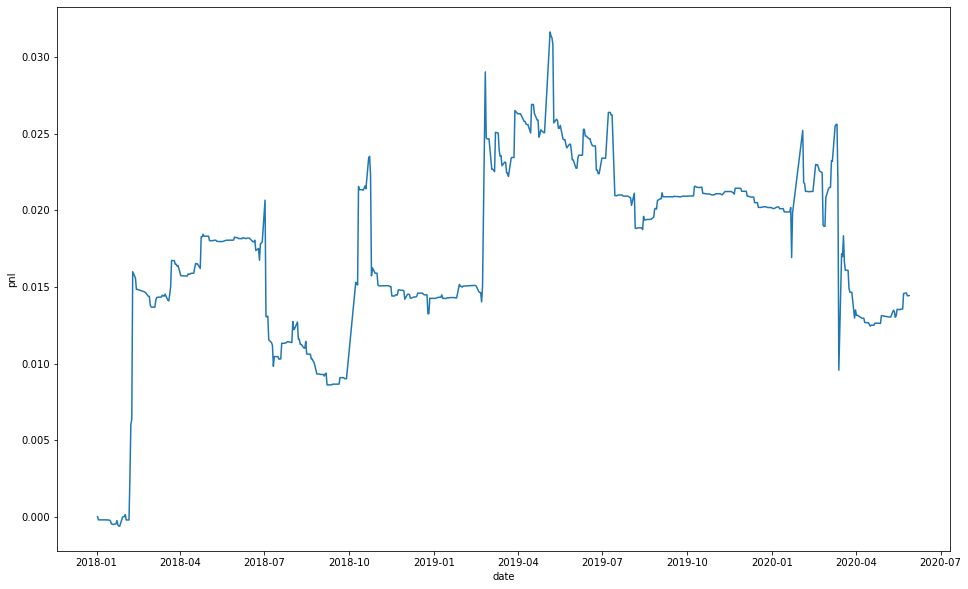

In [128]:
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], test_pca.cumsum());

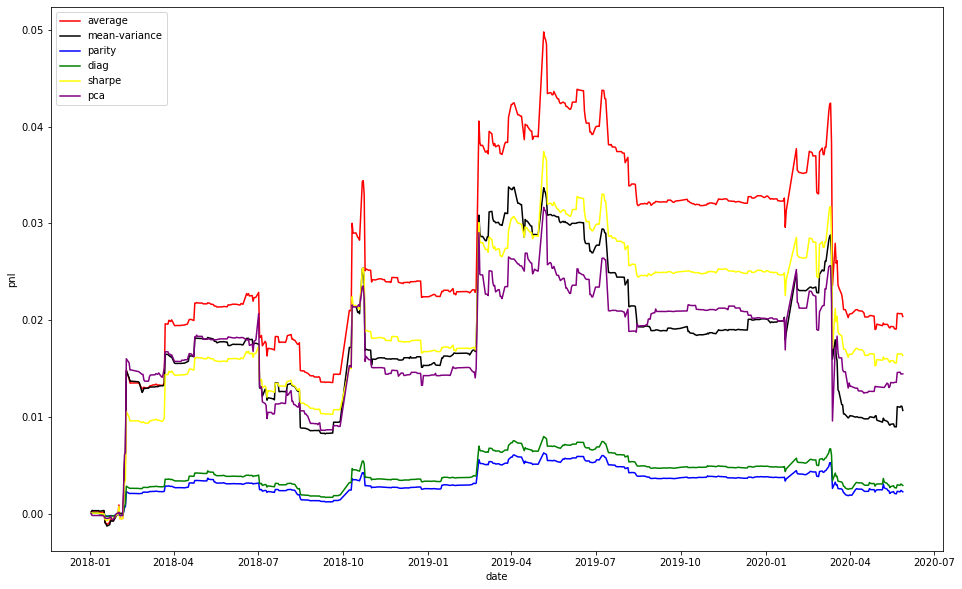

In [129]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(1, figsize=(16, 10))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
avg_plot, = plt.plot(format_dates[test_sample], avg_portfolio[test_sample].cumsum(), color="red", label="average");
mean_plot, = plt.plot(format_dates[test_sample], test_pnl.cumsum(), color="black", label="mean-variance");
parity_plot, = plt.plot(format_dates[test_sample], test_parity.cumsum(), color="blue", label="parity");
diag_plot, = plt.plot(format_dates[test_sample], test_diagonal.cumsum(), color="green", label="diag");
sharpe_plot, = plt.plot(format_dates[test_sample], test_sharpe.cumsum(), color="yellow", label="sharpe");
pca_plot, = plt.plot(format_dates[test_sample], test_pca.cumsum(), color="purple", label="pca");
plt.legend(handles=[avg_plot,mean_plot,parity_plot, diag_plot, sharpe_plot, pca_plot])